# Virginia House of Delegates Districting Tradeoffs
This notebook explores tradeoffs between various redistricting criteria, especially percent black voting-age population, in Virginia, using a dataset of 10,000 districting plans built out of precincts collected using GerryChain's ReCom algorithm.


In [159]:
import csv
import os
from functools import partial
import json

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper
from gerrychain.proposals import recom, flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

import tqdm

from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [160]:
newdir = "./VA_Outputs/"
#os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
#with open(newdir + "init.txt", "w") as f:
    #f.write("Created Folder")

In [161]:
#unique_label = "loc_prec"
#pop_col = "TOTPOP"
#district_col = "CD"

#graph_path = "./VA_precincts/VA_precincts.shp"

#graph = Graph.from_file(graph_path, reproject = False)

#graph.to_json("va_json.json")

In [162]:
jgraph = Graph.from_json("va_json.json")

In [163]:
graph_path = "./VA_precincts/VA_precincts.shp"

unique_label = "loc_prec"
pop_col = "TOTPOP"
district_col = "CD"

df = gpd.read_file(graph_path)

def num_splits(partition):
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby("precinct")["current"].nunique() > 1)
    return splits

In [164]:
def avg_pop_dist(partition):
    ideal_population = sum(partition["population"].values()) / len(
    partition
)
    total_deviation = sum([abs(v - ideal_population) for v in partition['population'].values()])
    return (total_deviation)/len(partition)

def pop_dist_pct(partition):
    ideal_population = ideal_population = sum(partition["population"].values()) / len(
    partition)
    total_deviation = total_deviation = sum([abs(v - ideal_population) for v in partition['population'].values()])
    avg_dist = total_deviation/len(partition)
    return avg_dist/ideal_population

my_updaters = {
    "cut_edges": cut_edges,
    "population": updaters.Tally("TOTPOP", alias = "population"),
    "avg_pop_dist": avg_pop_dist,
    "pop_dist_pct" : pop_dist_pct,
    "area": updaters.Tally("Area", alias = "area"),
    "perimeter": updaters.Tally("Perimeter", alias = "perimeter")
}

In [165]:
df["nBVAP"] = df["VAP"] - df["BVAP"]
df.round({"VAP": 1, "BVAP": 1, "nBVAP": 1})
df["G18DSEN"] = df["G18DSEN"].astype(float)
df["G18RSEN"] = df["G18RSEN"].astype(float)
df["G17DGOV"] = df["G17DGOV"].astype(float)
df["G17RGOV"] = df["G17RGOV"].astype(float)
df["G16DPRS"] = df["G16DPRS"].astype(float)
df["G16RPRS"] = df["G16RPRS"].astype(float)

In [166]:
num_elections = 4

election_names = [
    "G18SEN",
    "G17GOV",
    "G16PRS",
    "BVAPs"
]

election_columns = [
    [df["G18DSEN"], df["G18RSEN"]],
    [df["G17DGOV"], df["G17RGOV"]],
    [df["G16DPRS"], df["G16RPRS"]],
    [df["BVAP"], df["nBVAP"]],
]

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)

In [167]:
num_dist = 100
initial_partition = Partition(jgraph, "HDIST_11", my_updaters)
pop = sum(initial_partition["population"].values())
random_plan = recursive_tree_part(jgraph, range(num_dist), pop/num_dist, "TOTPOP", 0.01, 1)
initial_partition = Partition(jgraph, random_plan, my_updaters)

8001023.99956965
random


In [171]:
ideal_population = pop / len(initial_partition)

proposal = partial(
    recom, pop_col="TOTPOP", pop_target=ideal_population, epsilon=0.1, node_repeats=5
)

In [172]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

In [173]:
chain_length = 10000

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, .05),
        compactness_bound,  # single_flip_contiguous#no_more_discontiguous
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=chain_length,
)

pop_vec = []
cut_vec = []
mms_vec = []
egs_vec = []
pop_dist_vec = []
pop_pct_vec = []
splits = []
pol_pop = []
votes = [[],[],[],[]]

t=0

for part in chain.with_progress_bar():
    splits.append(num_splits(part))
    pop_dist_vec.append(avg_pop_dist(part))
    pop_vec.append(sorted(list(part["population"].values())))
    cut_vec.append(len(part["cut_edges"]))
    mms_vec.append([])
    egs_vec.append([])
    pop_pct_vec.append(pop_dist_pct(part))
    pol_pop.append(polsby_popper(part))
    
    for elect in range(num_elections):
        votes[elect].append(sorted(part[election_names[elect]].percents("Democratic")))
        mms_vec[-1].append(mean_median(part[election_names[elect]]))
        egs_vec[-1].append(efficiency_gap(part[election_names[elect]]))
    
    

/miniconda3/envs/VRDI/lib/python3.7/site-packages/gerrychain/updaters/tally.py:35: UserWarning: ignoring nan encountered at node '964' for attribute 'Democratic'
  node, self.alias
/miniconda3/envs/VRDI/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [174]:
opp_dists = []
for i in range(chain_length):
    q = 0
    for j in range(num_dist):
        if votes[3][i][j] >= 0.37 and votes[3][i][j] <= 0.55:
            q +=1
    opp_dists.append(q)

<IPython.core.display.Javascript object>


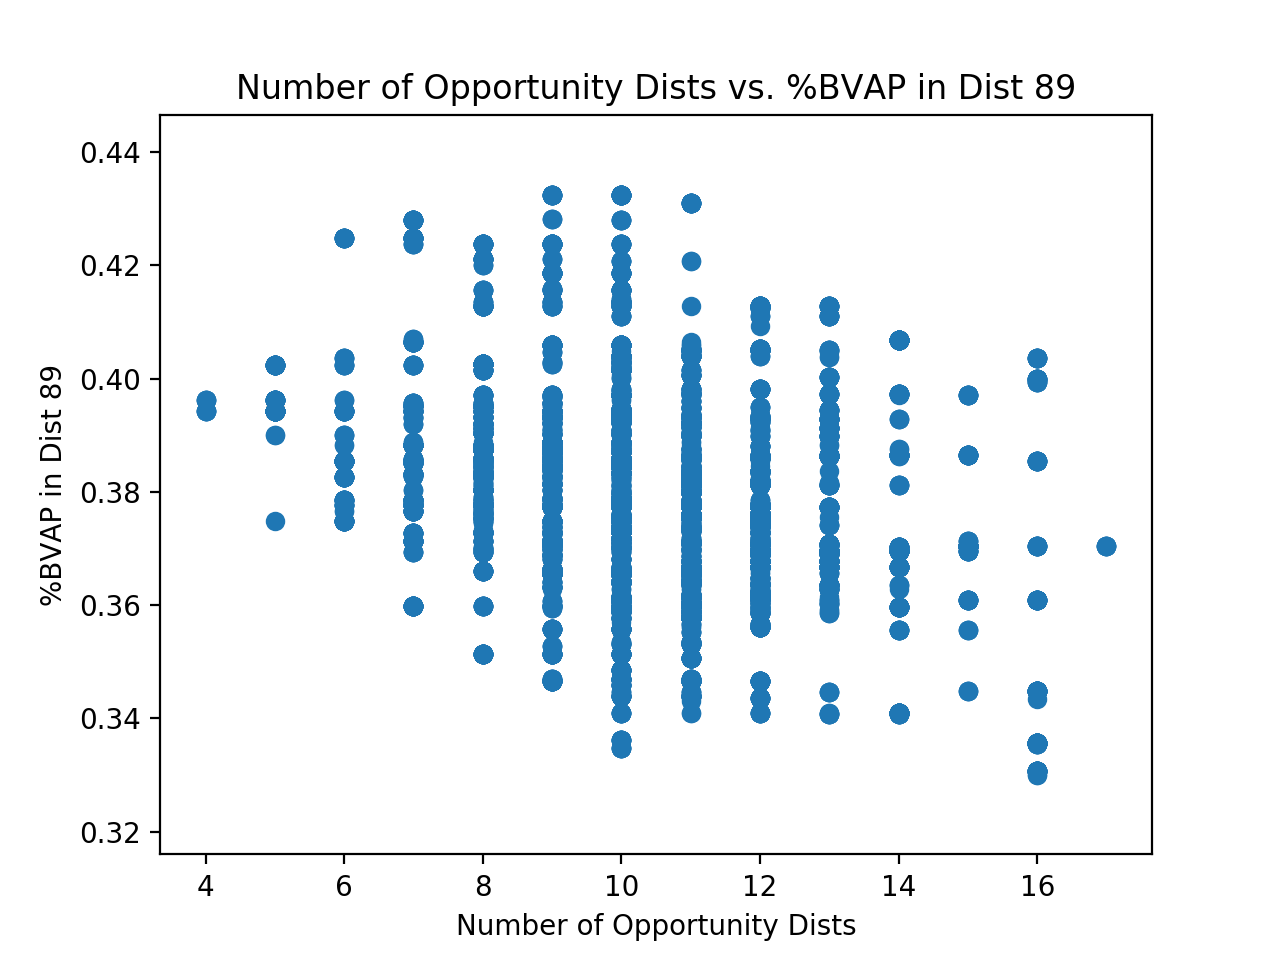

Text(0, 0.5, '%BVAP in Dist 89')

In [175]:
plt.scatter(opp_dists, bvaps_imp[8])
plt.title("Number of Opportunity Dists vs. %BVAP in Dist 89")
plt.xlabel("Number of Opportunity Dists")
plt.ylabel("%BVAP in Dist 89")
#plt.savefig("oppdist_89.png")

In [439]:
bvaps_1_2 = []
for i in range(chain_length):
    votes[3][i].sort()
    bvaps_1_2.append([votes[3][i][10], votes[3][i][9]])

In [176]:
for i in range(chain_length):
    votes[3][i].sort()

In [177]:
bvp_by_dist = []
for k in range(num_dist):
    bvp_by_dist.append([])
for i in range(chain_length):
    for j in range(num_dist):
        bvp_by_dist[j].append(votes[3][i][j])

In [178]:
bvp_by_run = [votes[3][i] for i in range(chain_length)]

<IPython.core.display.Javascript object>


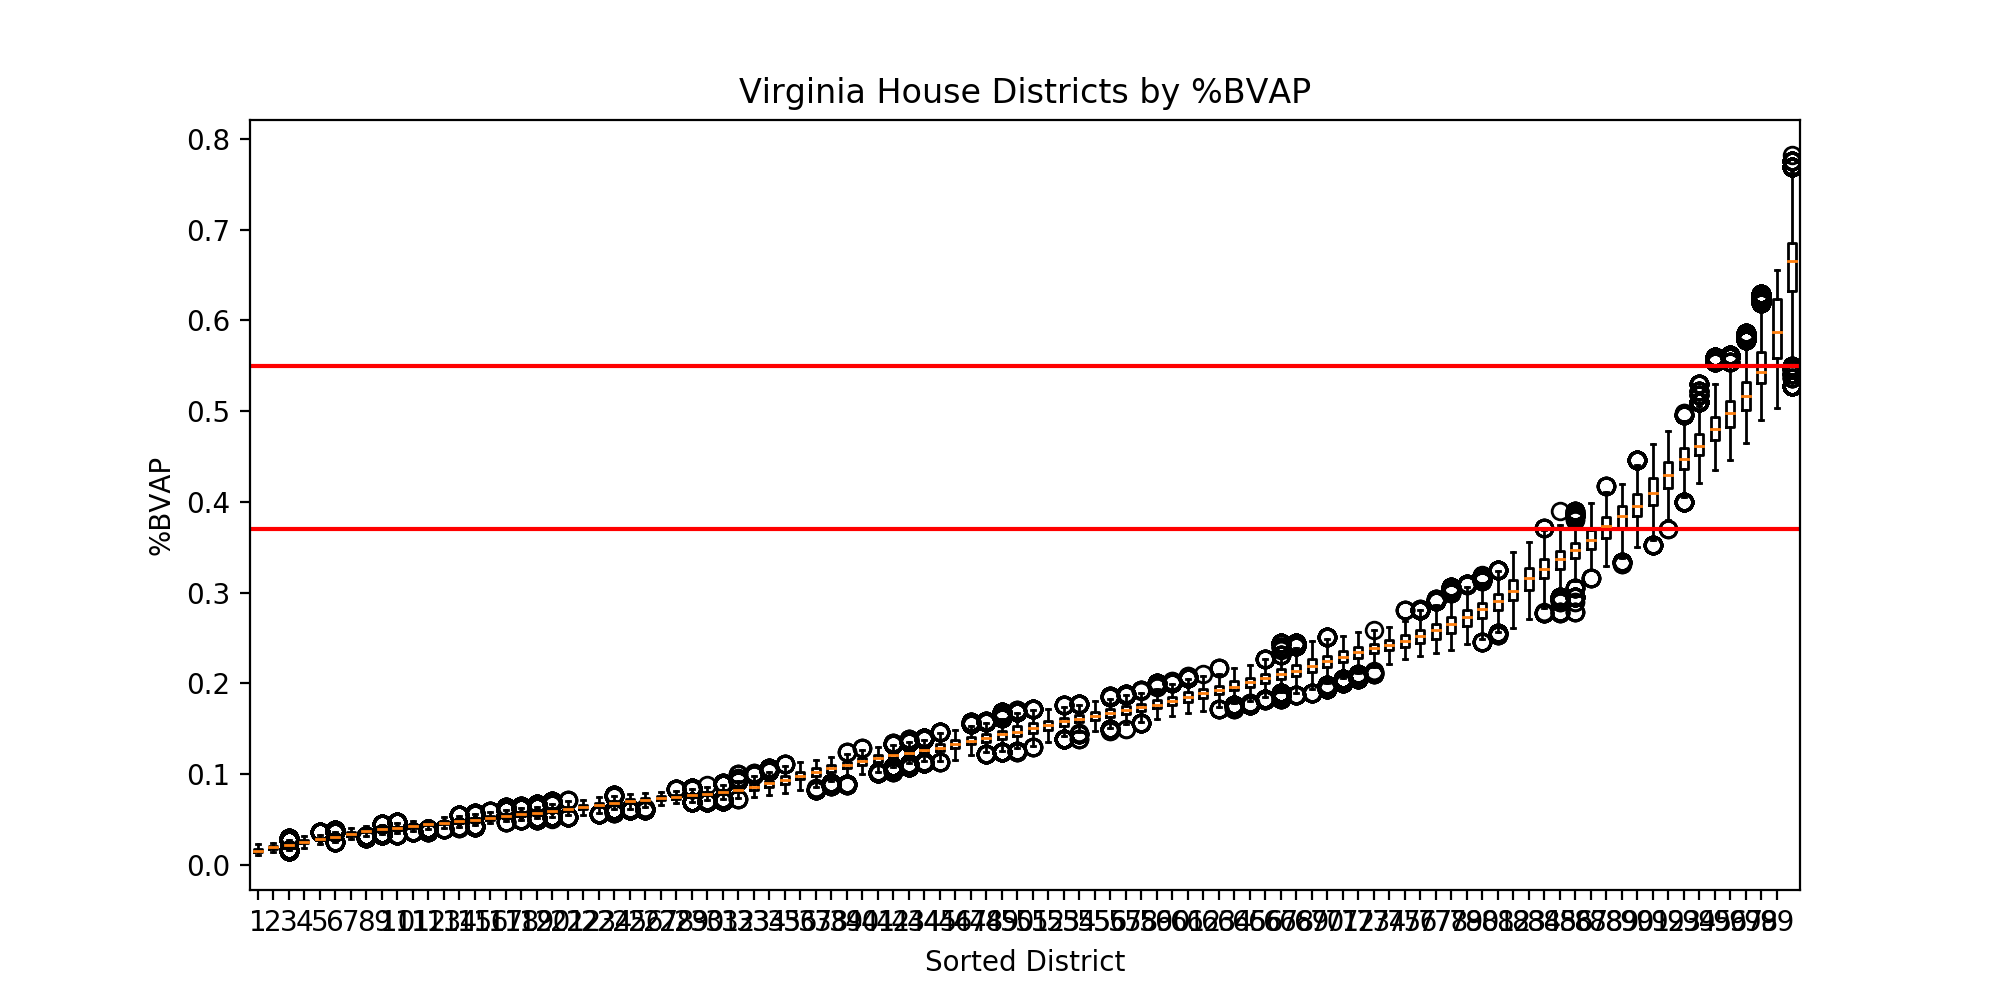

Text(0.5, 1.0, 'Virginia House Districts by %BVAP')

In [179]:
plt.figure(figsize = (10,5))
plt.boxplot(bvp_by_dist)
plt.axhline(0.37, color="red", label="37%")
plt.axhline(0.55, color = "red", label="55%")
plt.xticks(np.arange(1,100), [str(u) for u in range(1,101)])
plt.xlabel("Sorted District")
plt.ylabel("%BVAP")
plt.title("Virginia House Districts by %BVAP")

In [97]:
bvaps_imp = []
for k in range(80, 100):
    bvaps_imp.append(bvp_by_dist[k])

<IPython.core.display.Javascript object>


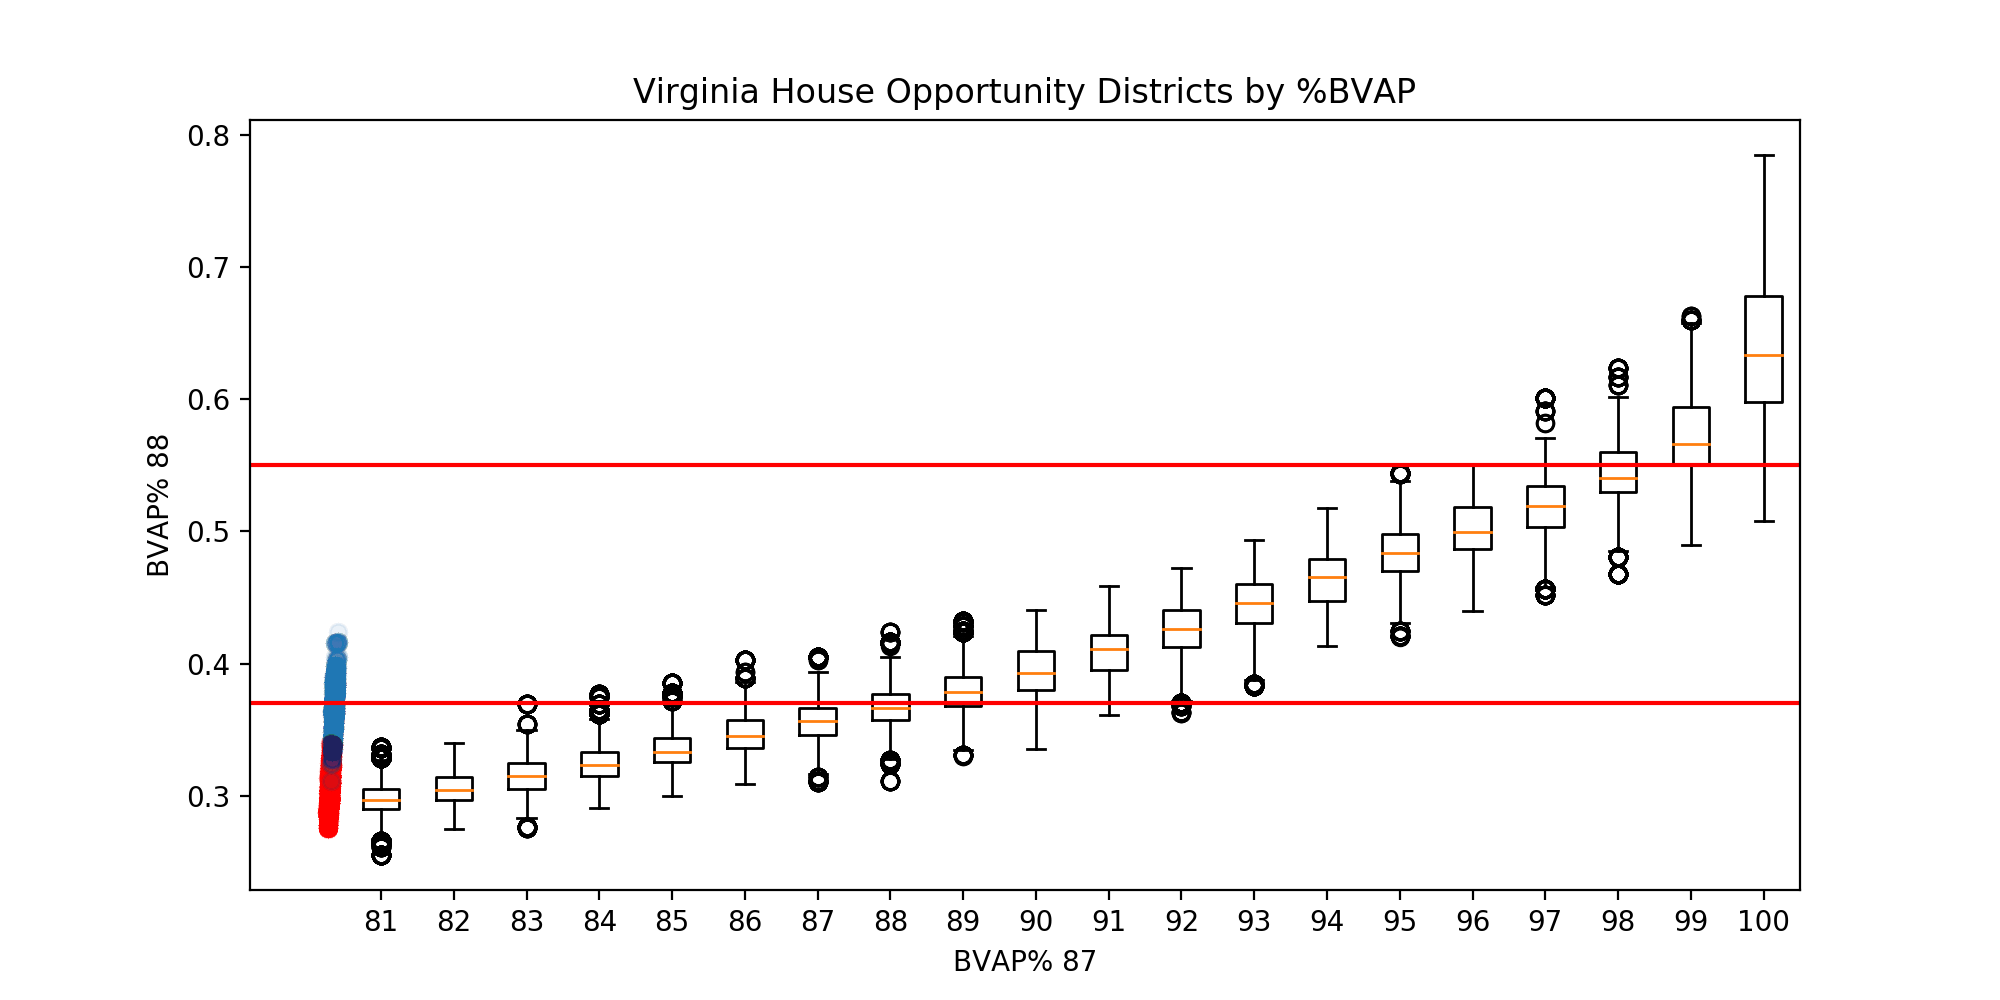

Text(0.5, 1.0, 'Virginia House Opportunity Districts by %BVAP')

In [180]:
plt.figure(figsize = (10,5))
plt.boxplot(bvaps_imp)
plt.axhline(0.37, color="red", label="37%")
plt.axhline(0.55, color = "red", label="55%")
plt.xticks(np.arange(1,21), [str(u) for u in range(81,101)])
plt.xlabel("Sorted District")
plt.ylabel("%BVAP")
plt.title("Virginia House Opportunity Districts by %BVAP")

<IPython.core.display.Javascript object>


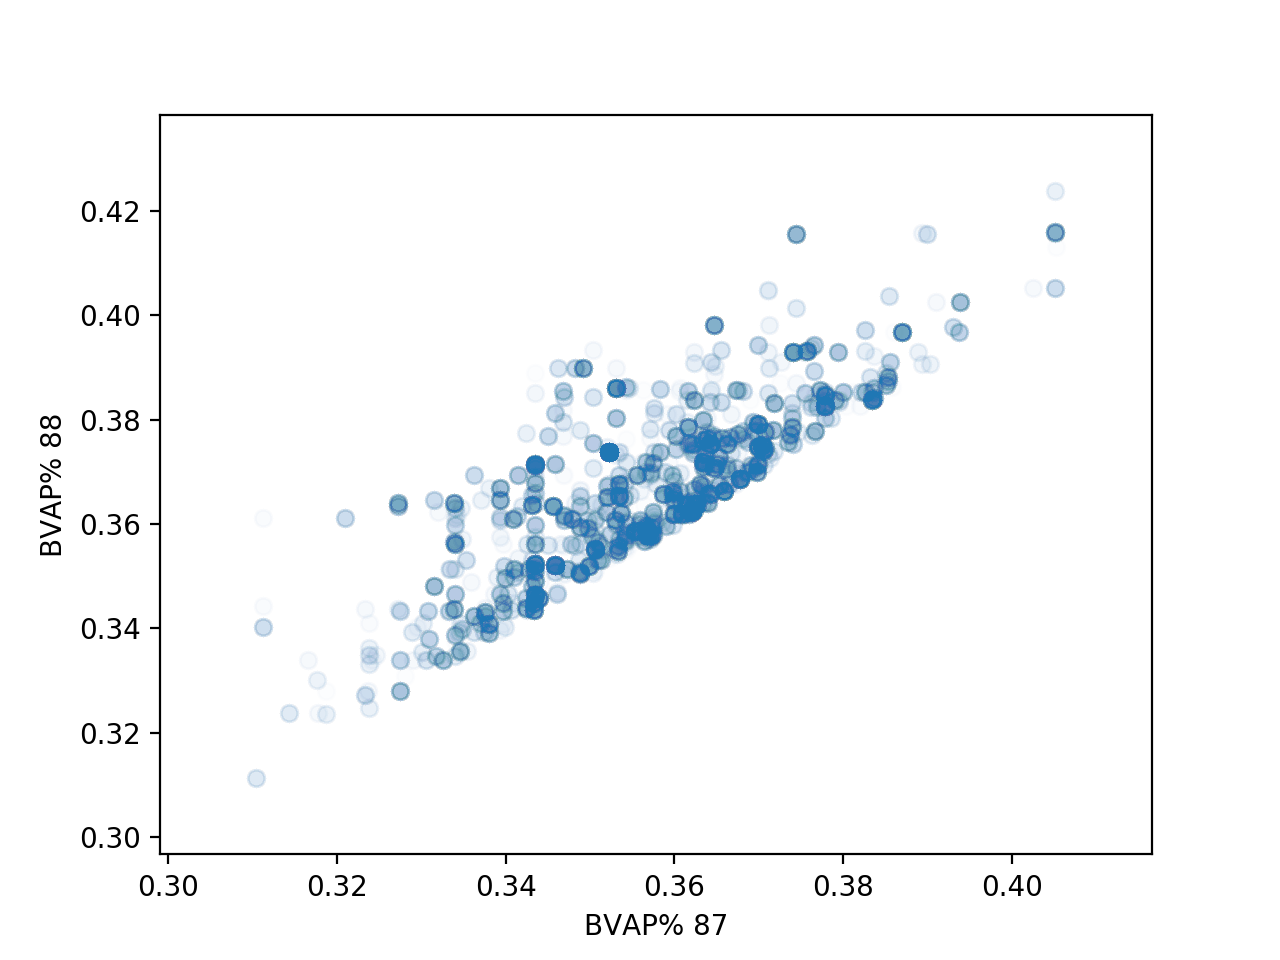

Text(0, 0.5, 'BVAP% 88')

In [184]:
plt.figure()
plt.scatter(bvaps_imp[6],bvaps_imp[7], alpha = 0.01)
plt.xlabel("BVAP% 87")
plt.ylabel("BVAP% 88")
#plt.savefig("bvap_87_88.png")

<IPython.core.display.Javascript object>


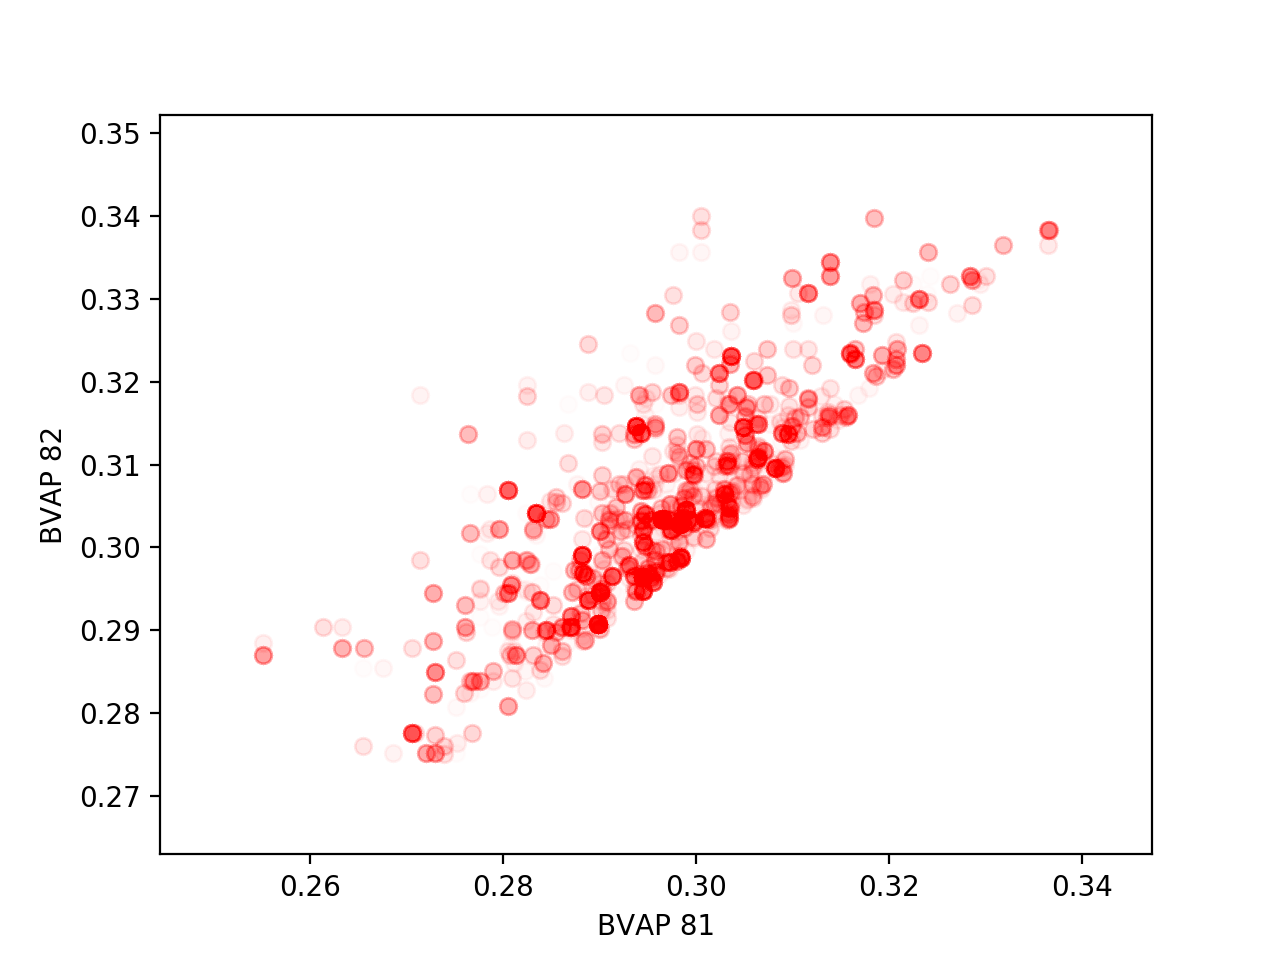

Text(0, 0.5, 'BVAP 82')

In [185]:
plt.figure()
plt.scatter(bvaps_imp[0], bvaps_imp[1], alpha = 0.01, color = "red")
plt.xlabel("BVAP 81")
plt.ylabel("BVAP 82")
#plt.savefig("bvap_81_82.png")

<IPython.core.display.Javascript object>


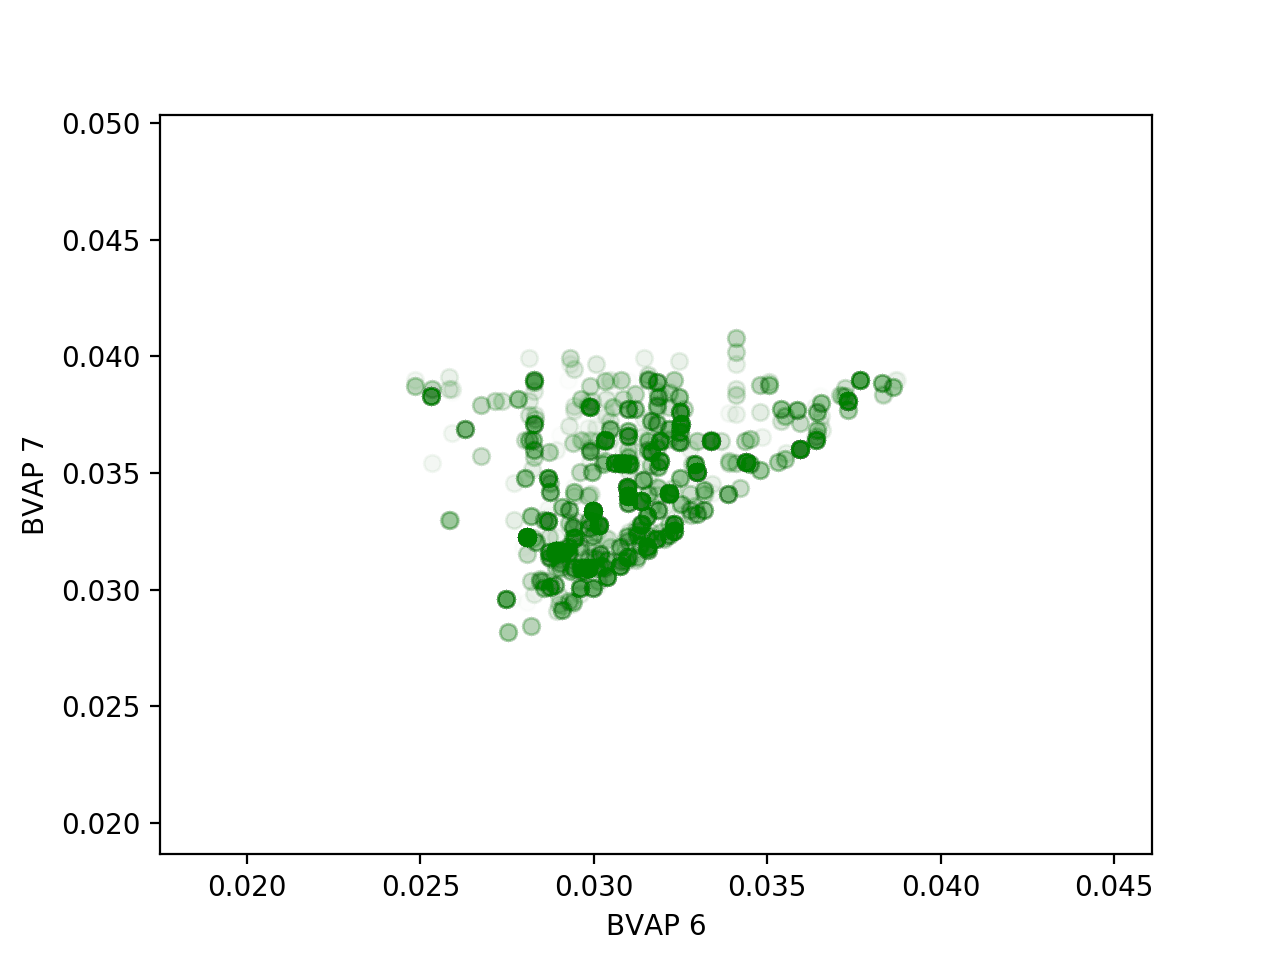

Text(0, 0.5, 'BVAP 7')

In [186]:
plt.figure()
plt.scatter(bvp_by_dist[5], bvp_by_dist[6], alpha = 0.01, color = "green")
plt.xlabel("BVAP 6")
plt.ylabel("BVAP 7")
#plt.savefig("bvap_6_7.png")

In [187]:
mms_new = []
for i in range(chain_length):
    mms_new.append(mms_vec[i][0])

In [188]:
egs_new = []
for i in range(chain_length):
    egs_new.append(egs_vec[i][0])

In [189]:
pol_pop_new = []
for i in range(chain_length):
    pol_pop_new.append(min(pol_pop[i].values()))

In [458]:
#va_10k_df = pd.DataFrame(list(zip(bvaps_imp, pop_pct_vec, mms_new, egs_new, pol_pop_new)), columns = ["top_20_districts", "pop_pct_dev", "mm_score_SEN18","eg_score_SEN18", "min_pol_pop"])

In [459]:
#va_10k_df.to_csv(r'va_10k_bvaps.csv', index = None, header = True)

In [190]:
#compute mean BVAP in opportunity districts in each plan
bvp_for_mean = []
for i in range(chain_length):
    bvp_for_mean.append([])
    for j in range(num_dist):
        if bvp_by_run[i][j] <= 0.55 and bvp_by_run[i][j] >= 0.37:
            bvp_for_mean[i].append(bvp_by_run[i][j])


In [191]:
np.mean(bvp_for_mean[0])

0.43797666518647754

In [192]:
opp_dist_bvp_means = [np.mean(bvp_for_mean[i]) for i in range(chain_length)]

<IPython.core.display.Javascript object>


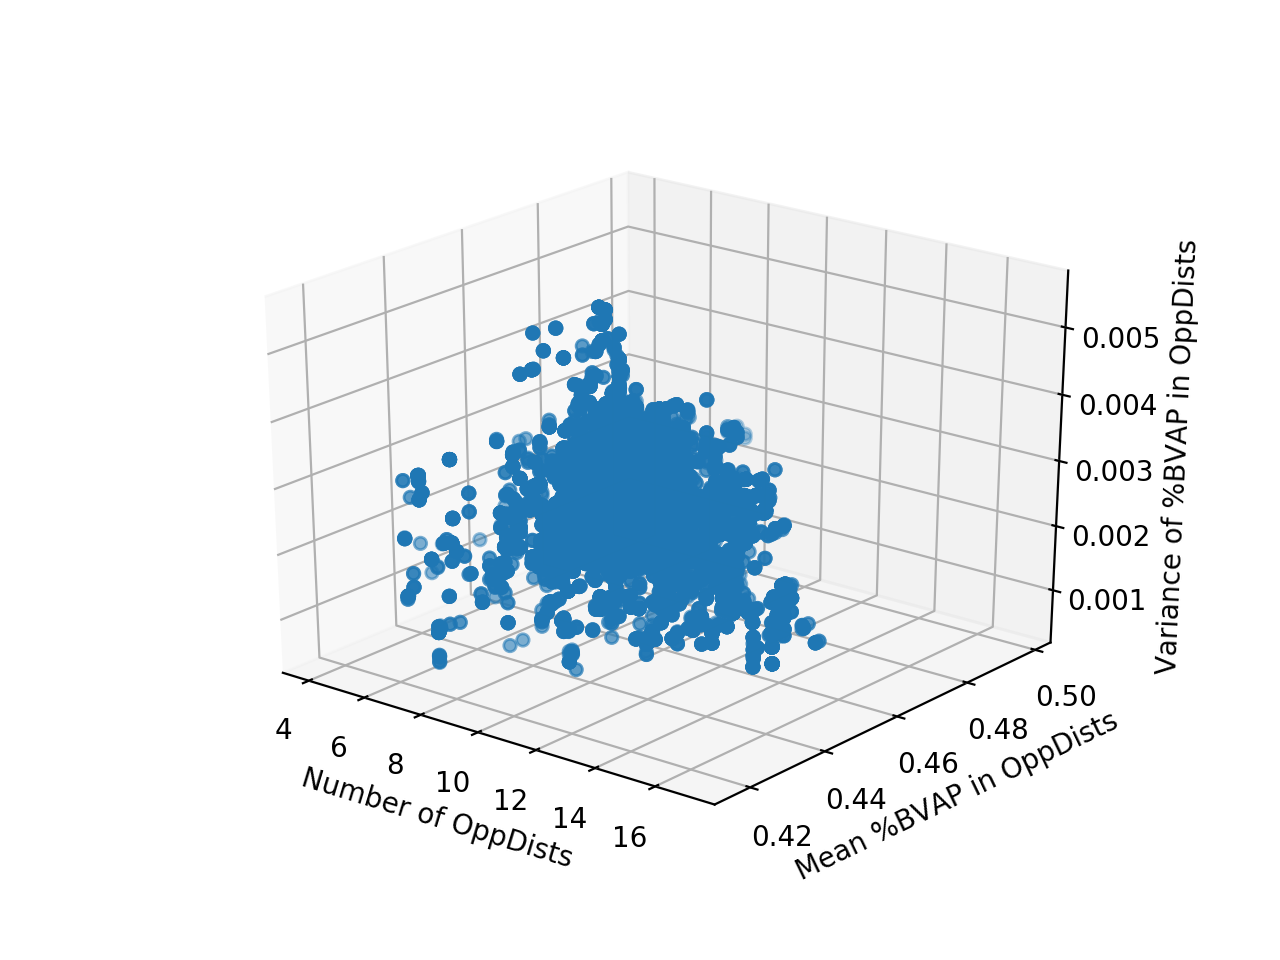

In [193]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = opp_dists
y=opp_dist_bvp_means
z = opp_dist_bvp_var
ax.set_xlabel("Number of OppDists")
ax.set_ylabel("Mean %BVAP in OppDists")
ax.set_zlabel("Variance of %BVAP in OppDists")
ax.scatter(x,y,z)

#plt.scatter(opp_dists, opp_dist_bvp_means, opp_dist_bvp_var)

In [131]:
opp_dist_bvp_var = [np.var(bvp_for_mean[i]) for i in range(chain_length)]

In [194]:
from gerrychain import Partition

class ParetoCollection:
    """
    Calculates the Pareto front over a given set of scores for an arbitrary
    number of partitions.
    """
    def __init__(self, updaters):
        """
        :param updaters: The updaters to track.
        """
        self.updaters = updaters
        self.points = []

    def add(self, partitions):
        """Adds scores from one or more ``Partition``."""
        if isinstance(partitions, dict):
            if all(updater in partitions for updater in self.updaters):
                self.points.append(partitions)
        elif isinstance(partitions, Partition):
            self.points.append({updater: partitions[updater]
                                for updater in self.updaters})
        else:
            for partition in partitions:
                self.add(partition)

    def front(self, updaters=None, maxima=True):
        """
        Calculates the Pareto front over the collected set of scores.
        :param updaters: The subset of updaters to calculate the Pareto front
        over. If not specified, all tracked updaters are used.
        """
        # "Braindead" algorithm (to replace later)
        if not updaters:
            updaters = self.updaters
        if not self.points:
            return []
        optimal = [True] * len(self.points)
        traversed = [False] * len(self.points)
        queue = [0]
        while queue:
            idx = queue.pop()
            if traversed[idx]: continue
            traversed[idx] = True
            dominates, dominated_by = status(self.points, self.points[idx],
                                             updaters, optimal, maxima)
            for dom_idx in dominates:
                # If a point is dominated by at least one other point,
                # it cannot be optimal.
                optimal[dom_idx] = False
                traversed[dom_idx] = True
            to_queue = []
            if dominated_by:
                # If the point we're considering is dominated by
                # at least one other point, it can't be optimal.
                optimal[idx] = False
                for dom_idx in dominated_by:
                    if optimal[dom_idx] and not traversed[dom_idx]:
                        to_queue.append(dom_idx)
            if not to_queue:
                for point_idx, point_traversed in enumerate(traversed):
                    to_queue = []
                    if not point_traversed:
                        to_queue.append(point_idx)
                        break
            queue += to_queue
                
        return [self.points[idx] for idx, point_optimal
                in enumerate(optimal) if point_optimal]
    
    def __repr__(self):
        return (f'ParetoCollection ({len(self.points)} points, ' +
                f'{len(self.updaters)} dimensions)')
    
def status(points, compare_point, dimensions, optimal, maxima):
    point_dominates = []
    point_dominated_by = []
    for idx, point in enumerate(points):
        if optimal[idx]:
            if dominates(compare_point, point, dimensions):
                if maxima:
                    point_dominates.append(idx)
                else:
                    point_dominated_by.append(idx)
            elif dominates(point, compare_point, dimensions):
                if maxima:
                    point_dominated_by.append(idx)
                else:
                    point_dominates.append(idx)
    return point_dominates, point_dominated_by

def dominates(a, b, dimensions):
    """Determines if point a dominates point b."""
    geq = 0
    greater = False
    for dim in dimensions:
        if a[dim] > b[dim]:
            greater = True
        if a[dim] >= b[dim]:
            geq += 1
    return greater and geq == len(dimensions)

In [202]:
va_bvap_data = pd.DataFrame(list(zip(bvp_by_run, opp_dists, opp_dist_bvp_means, opp_dist_bvp_var)), columns = ["%BVAP","Number of Opportunity Districts", "Mean %BVAP in Opportunity Districts", "Variance of %BVAP in Opportunity Districts"])

In [205]:
va_bvap_data.to_csv(r'va_vbap_data.csv', index = None, header = True)

<IPython.core.display.Javascript object>


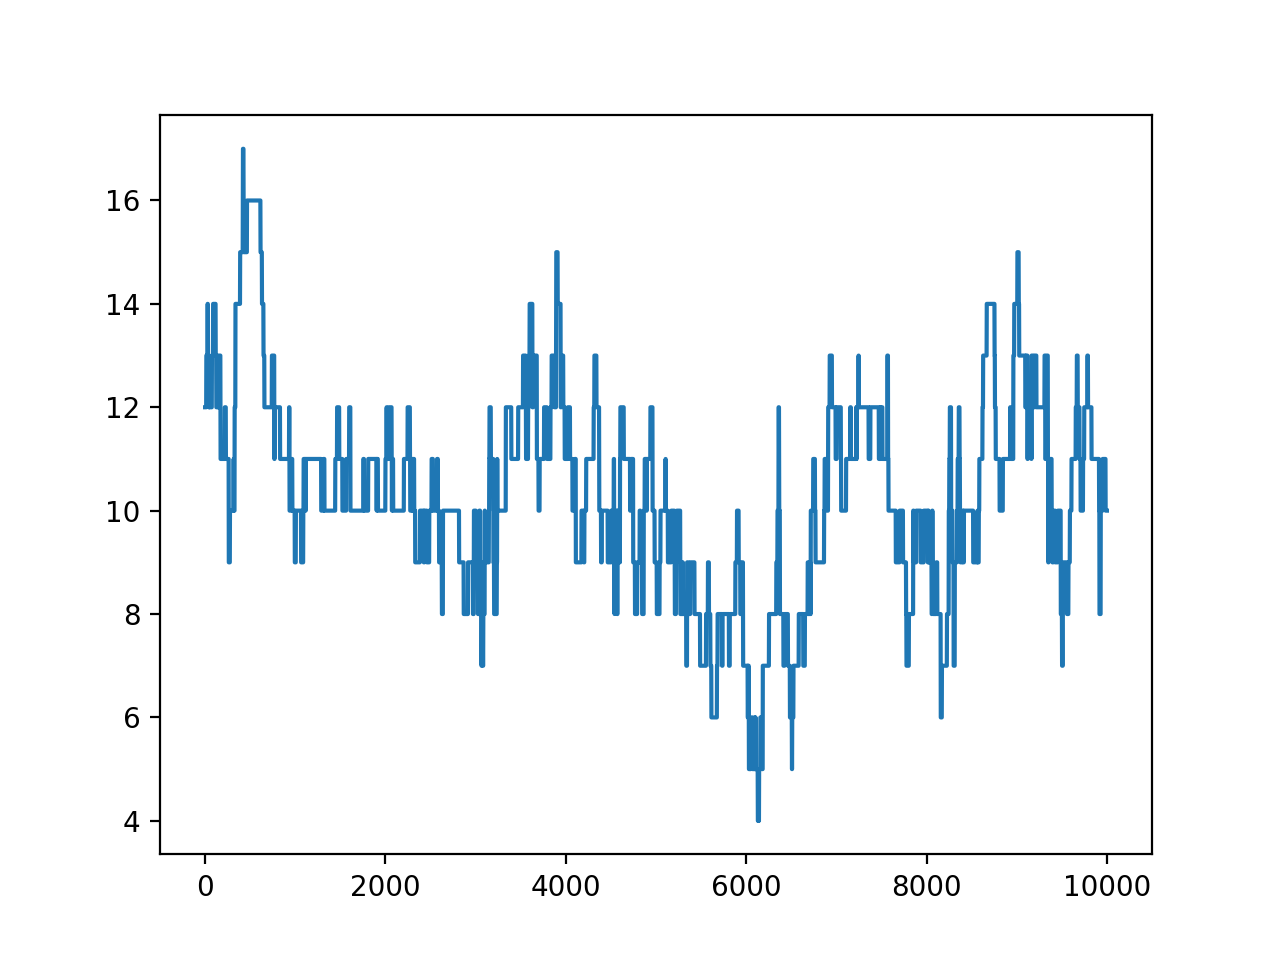

In [204]:
plt.figure()
plt.plot(opp_dists)